In [1]:
from io import BytesIO
from pathlib import Path

import boto3
import contextily as ctx
import datashader as ds
import duckdb
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rio
import s2sphere
from botocore.config import Config
from owslib.wfs import WebFeatureService

project_root = Path.cwd().parent

In [2]:
def load_raster_data(url, filename=None):
    if filename:
        p = f"zip+{url}!{filename}"
    else:
        p = url
    return rio.open_rasterio(p, masked=True)


def load_wfs_layer(layer_name):
    wfs_url = "https://idecor-ws.mapascordoba.gob.ar/geoserver/idecor/wfs"
    srs = "EPSG:22174"

    # Initialize WFS connection
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")

    # Get the data
    response = wfs.getfeature(typename=layer_name, srsname=srs)

    # Read the response into a GeoDataFrame
    return gpd.read_file(BytesIO(response.read()))

In [3]:
# Load Nono boundary data and project to Web Mercator once
nono = load_wfs_layer("idecor:radios_urbanos")
nono = nono[nono["nombre"] == "NONO"]
nono_3857 = nono.to_crs(epsg=3857)

# Load water courses data and project directly to Web Mercator
cursos_agua = load_wfs_layer("idecor:cursos_agua")
cursos_agua_3857 = cursos_agua.to_crs(epsg=3857)
cursos_agua_nono_3857 = gpd.clip(cursos_agua_3857, nono_3857)


In [4]:
# Load flood depth data
flood_depth_url = "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/CEMS-GLOFAS/flood_hazard/RP100/ID74_S30_W70_RP100_depth.tif"
flood_depth = load_raster_data(flood_depth_url)

# Reproject to Web Mercator and clip to Nono extent
flood_depth_3857 = flood_depth.rio.reproject(
    dst_crs="EPSG:3857",
    resolution=100,  # 100m resolution
).rio.clip(nono_3857.geometry, from_disk=True)

In [5]:
# Load GHSL data
ghsl_url = (
    "https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/"
    "GHS_POP_GLOBE_R2023A/"
    "GHS_POP_E2025_GLOBE_R2023A_54009_100/"
    "V1-0/"
    "tiles/"
    "GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.zip"
)
ghsl = load_raster_data(
    ghsl_url, "GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R13_C13.tif"
)

# Reproject and clip GHSL data in one step
ghsl_3857 = ghsl.rio.reproject(
    dst_crs="EPSG:3857",
    resolution=100,  # 100m resolution
).rio.clip(nono_3857.geometry)


In [6]:
# Calculate centroid in Web Mercator first
center = nono_3857.geometry.centroid.iloc[0]

# Convert the centroid point to WGS84 for S2
center_wgs84 = gpd.GeoDataFrame(geometry=[center], crs="EPSG:3857").to_crs(epsg=4326)
center = center_wgs84.geometry.iloc[0]

# Get the S2 cell ID at level 10
cell = s2sphere.CellId.from_lat_lng(
    s2sphere.LatLng.from_degrees(center.y, center.x)
).parent(10)

# Configure S3 client for Source Cooperative
s3 = boto3.client(
    "s3",
    endpoint_url="https://data.source.coop",
    aws_access_key_id="",
    aws_secret_access_key="",
    config=Config(s3={"addressing_style": "path"}),
)

# List objects in the Argentina directory
response = s3.list_objects_v2(
    Bucket="vida",
    Prefix="google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/",
)

# Extract partition IDs from the keys
partitions = {
    obj["Key"].split("/")[-1].replace(".parquet", "")
    for obj in response.get("Contents", [])
}

# Check each level up to find a matching partition
for level in range(10, 0, -1):
    parent_id = str(cell.parent(level).id())
    print(f"Level {level}: {parent_id}")

    if parent_id in partitions:
        print(f"Found match at level {level}!")
        break

# Initialize DuckDB connection
con = duckdb.connect()

# Install and load required extensions
con.execute("INSTALL spatial")
con.execute("LOAD spatial")

# Configure S3 settings
con.execute("SET s3_region='us-east-1'")  # or whatever region is appropriate
con.execute("SET s3_endpoint='data.source.coop'")  # Note: removed https://
con.execute("SET s3_use_ssl=true")
con.execute("SET s3_url_style='path'")

# Convert Nono to WGS84 for spatial query
nono_wkt = nono_3857.to_crs(epsg=4326).geometry.iloc[0].wkt

# Now query with spatial filtering
query = f"""
SELECT 
    ST_AsText(geometry) as geometry_wkt,
    *
FROM read_parquet('s3://vida/google-microsoft-open-buildings/geoparquet/by_country_s2/country_iso=ARG/{parent_id}.parquet')
WHERE ST_Intersects(geometry, ST_GeomFromText('{nono_wkt}'))
"""
# query takes about 1.5 minutes to run
buildings = con.execute(query).df()

# Create GeoDataFrame using the WKT geometry column
buildings = gpd.GeoDataFrame(
    buildings,
    geometry=gpd.GeoSeries.from_wkt(buildings["geometry_wkt"]),
    crs="EPSG:4326",
)

buildings_3857 = buildings.to_crs(epsg=3857)

Level 10: 10677235371542052864
Level 9: 10677238670076936192
Level 8: 10677243068123447296
Level 7: 10677260660309491712
Level 6: 10677190291565314048
Level 5: 10676908816588603392
Level 4: 10678034716495446016
Level 3: 10682538316122816512
Found match at level 3!


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [10]:
# Create GeoDataFrame using the WKT geometry column
buildings = gpd.GeoDataFrame(
    buildings,
    geometry=gpd.GeoSeries.from_wkt(buildings["geometry_wkt"]),
    crs="EPSG:4326",
)

buildings_3857 = buildings.to_crs(epsg=3857)

<Axes: >

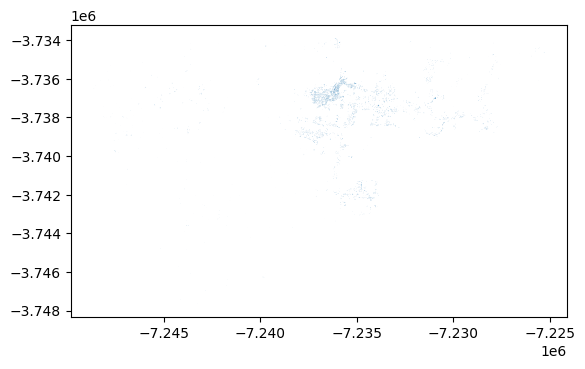

In [18]:
buildings_3857.plot()

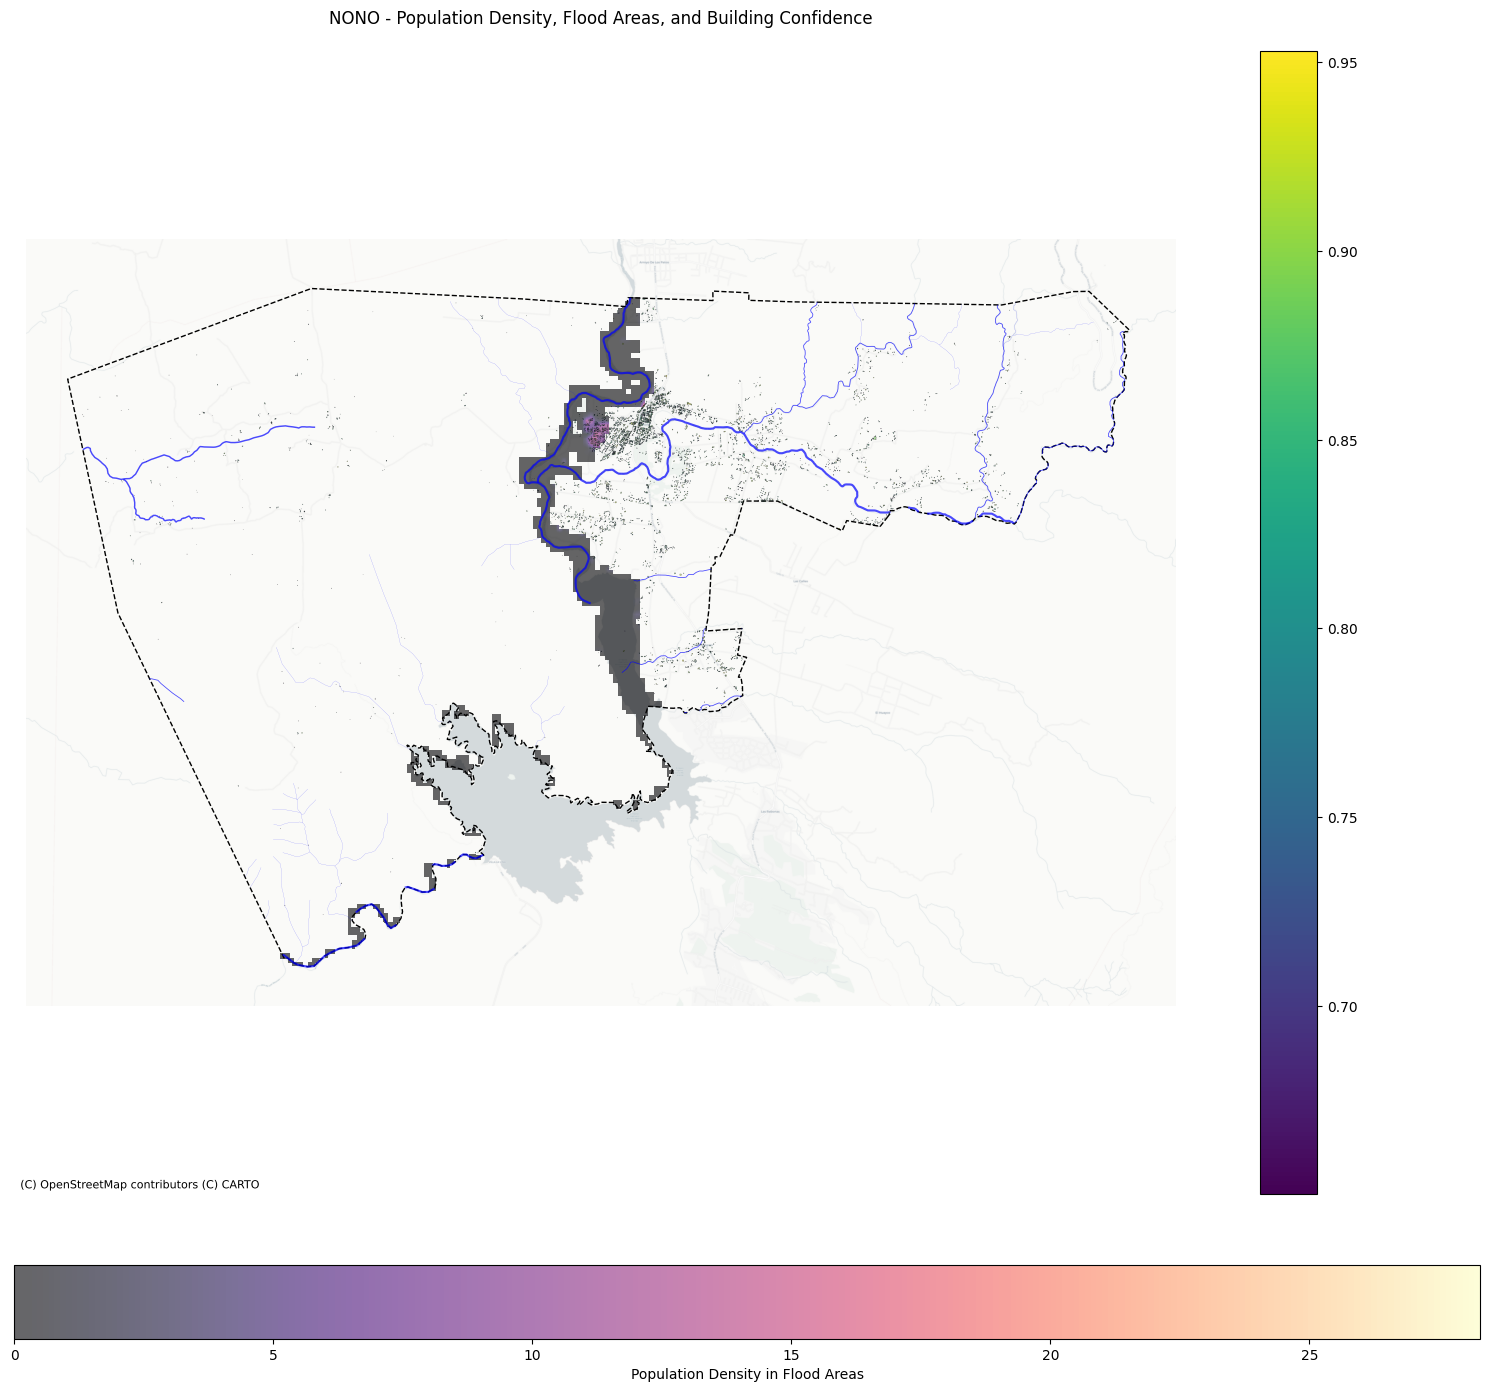

In [20]:
# Create a function to scale the line widths
def scale_line_width(orden):
    return 2 - (orden - 1) * (1.9 / 4)

# Create the map
fig, ax = plt.subplots(figsize=(15, 15))

# Set the plot limits to match the Nono boundary
bounds = nono_3857.total_bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

# Create datashader canvas
canvas = ds.Canvas(plot_width=1500, plot_height=1500)

# Create mask for flood areas (where flood depth > 0)
flood_mask = flood_depth_3857 > 0

# First rasterize the flood mask
flood_agg = canvas.raster(flood_mask.sel(band=1))

# Then rasterize GHSL data
ghsl_agg = canvas.raster(ghsl_3857.sel(band=1))

# Apply the mask to the rasterized data
masked_ghsl = ghsl_agg.where(flood_agg)

# Add basemap first with explicit zoom level
ctx.add_basemap(
    ax,
    crs=flood_depth_3857.rio.crs,
    source=ctx.providers.CartoDB.Positron,
    zorder=0,
    zoom=15,  # Set explicit zoom level
)

# Plot the masked population data
masked_ghsl.plot.imshow(
    ax=ax,
    alpha=0.6,
    cmap="magma",
    add_colorbar=True,
    cbar_kwargs={
        "label": "Population Density in Flood Areas",
        "orientation": "horizontal",
        "pad": 0.05,
        "location": "bottom",
    },
    zorder=1,
)

# Plot vector data
nono_3857.plot(
    ax=ax, facecolor="none", edgecolor="black", linestyle="--", linewidth=1, zorder=2
)

# Plot water courses
for orden in sorted(cursos_agua_nono_3857["orden"].unique()):
    subset = cursos_agua_nono_3857[cursos_agua_nono_3857["orden"] == orden]
    line_width = scale_line_width(orden)
    subset.plot(ax=ax, color="blue", linewidth=line_width, alpha=0.7, zorder=3)

# Plot buildings with confidence
buildings_3857.plot(
    column="confidence",
    ax=ax,
    legend=True,
    cmap="viridis",
    alpha=0.5,
    edgecolor="black",
    linewidth=0.3,
    zorder=4,
)

# Add title and labels
plt.title("NONO - Population Density, Flood Areas, and Building Confidence", pad=20)
plt.axis("equal")  # This ensures the plot isn't distorted

# Remove axis labels and ticks
ax.set_axis_off()

# Adjust layout to prevent legend overlap
plt.tight_layout()

plt.show()